<a href="https://colab.research.google.com/github/Abdelrahman-Mohamed-Taha-MAHMOUD/S-DISCO/blob/main/S_DISCO_2024_QSAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<center><h1>S-DISCO 2024 - QSAR</h1></center>**

---



## <u>**Installation of mandatory packages**</u>

In [1]:
# @title Installation of prerequisites
!pip install rdkit

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdFingerprintGenerator


from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
from sklearn.decomposition import PCA, KernelPCA
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans

import ipywidgets as widgets
from IPython.display import clear_output

import plotly.express as px

np.seterr(divide='ignore', invalid='ignore')

print("\n\n\033[1mPrerequisites succesfully installed !\033[0m")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 24.4 MB/s eta 0:00:00


Prerequisites succesfully installed !


In [2]:
# @title Python main functions
################################################################################

def getMolDescriptors(mol, missingVal=None):
    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        res[nm] = val
    return res

################################################################################

def elimcor_sansY(X, s=0.95):
    correl = np.corrcoef(X, rowvar=False)
    stop = False
    possetap = list(range(X.shape[1]))
    groupes = {i: [i] for i in range(X.shape[1])}

    while not stop:
        # Regroup variables for which |corr| > threshold
        gplist = {}
        possglob = list(range(correl.shape[0]))
        for i in range(correl.shape[0]):
            poss = possglob[:i] + possglob[i+1:]
            gplist[i] = [i] + [poss[j] for j in range(len(poss)) if abs(correl[i, poss[j]]) > s]

        # Sort groups from largest to smallest
        gplisteff = {k: len(v) for k, v in gplist.items()}
        if any(val > 1 for val in gplisteff.values()):
            gplistfin = {k: v for k, v in gplist.items() if gplisteff[k] > 1}
            gplistuniq = [k for k, v in gplisteff.items() if v == 1]
            gpsel = []
            for i in gplistfin.values():
                selloc = min(i)
                gploc = groupes[possetap[selloc]]
                for j in i:
                    gploc.extend(groupes[possetap[j]])
                groupes[possetap[selloc]] = list(set(gploc))
                gpsel.append(selloc)
            possetap = [val for idx, val in enumerate(possetap) if idx in gplistuniq or val in set(gpsel)]
            correl = np.corrcoef(X.iloc[:,possetap], rowvar=False)
        else:
            stop = True

    return {"possetap": possetap, "groups": list(groupes.values())}

################################################################################

print("\033[1mFunctions succesfully loaded !\033[0m")

Functions succesfully loaded !


## <u>**Ligands loading and descriptors generation**</u>

In [3]:
# @title Loading of the Glucocorticoid dataset

!wget https://github.com/cbedart/S-DISCO/raw/refs/heads/2023/mols_gr_tosave.pkl > /dev/null 2>&1
molecules_GR = pd.read_pickle("mols_gr_tosave.pkl")

# Removal of very high MW compounds
molecules_GR = molecules_GR.loc[[Descriptors.MolWt(i) < 800 for i in molecules_GR["RDKit"]]]
molecules_GR.index = range(len(molecules_GR))

molecules_GR

,BindingDB_ID,SMILES,RDKit,IC50,pIC50,Steroidal
0,50206900,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(ccc4[C@H]3[C...,<rdkit.Chem.rdchem.Mol object at 0x7df168873650>,0.03,10.523,0
1,50203432,CSc1ccc(cc1)[C@@H](Oc1ccc2n(ncc2c1)-c1ccc(F)cc...,<rdkit.Chem.rdchem.Mol object at 0x7df1688737e0>,0.03,10.523,0
2,50203441,C[C@H](NC(=O)C(F)(F)F)[C@H](Oc1ccc2n(ncc2c1)-c...,<rdkit.Chem.rdchem.Mol object at 0x7df168873790>,0.04,10.398,0
3,50203413,CCc1ccc(cc1)[C@@H](Oc1ccc2n(ncc2c1)-c1ccc(F)cc...,<rdkit.Chem.rdchem.Mol object at 0x7df1688736a0>,0.05,10.301,0
4,50250114,C[C@H](NC(=O)C(C)(F)F)[C@H](Oc1ccc2n(ncc2c1)-c...,<rdkit.Chem.rdchem.Mol object at 0x7df168873560>,0.05,10.398,0
...,...,...,...,...,...,...
1698,50216276,COc1cc(C[C@@H](C)[C@H](C)Cc2ccc(O)c(OC)c2)ccc1O,<rdkit.Chem.rdchem.Mol object at 0x7df1685a8ea0>,35000.00,4.456,0
1699,145862,CCCCCC(O)[C@@H]1C2CC3=C(COC(\C=C\C)=C3)C(=O)[C...,<rdkit.Chem.rdchem.Mol object at 0x7df1685c8ef0>,35000.00,4.456,0
1700,50318300,COC(=O)[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@@]23O[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7df1685c8f40>,35900.00,4.507,1
1701,50004233,Cc1c2[nH]c3ccccc3c2c(C)c2cnccc12,<rdkit.Chem.rdchem.Mol object at 0x7df1685f0f90>,90000.00,4.046,0


In [4]:
# @title Generation of 202 descriptors


print("\033[1mDescriptors are currently being generated. It will take ~2 min\033[0m")

desc_GR = pd.DataFrame(columns=["BindingDB_ID", "IC50", "pIC50", "Steroidal"] + [i for i,j in Descriptors._descList])

for i in range(len(molecules_GR)):
  desc_GR.loc[i] = molecules_GR.loc[i,["BindingDB_ID", "IC50", "pIC50", "Steroidal"]].tolist() + list(getMolDescriptors(molecules_GR.loc[i,"RDKit"], missingVal = np.NAN).values())

desc_GR_noNA = desc_GR.dropna(axis="columns")
desc_GR_noNA

Descriptors are currently being generated. It will take ~2 min


,BindingDB_ID,IC50,pIC50,Steroidal,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,50206900.0,0.03,10.523,0.0,14.364783,14.364783,0.642359,-5.443756,0.438299,63.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50203432.0,0.03,10.523,0.0,14.333574,14.333574,0.263251,-6.176700,0.245615,24.514286,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50203441.0,0.04,10.398,0.0,14.362434,14.362434,0.336341,-6.163428,0.290171,23.135135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50203413.0,0.05,10.301,0.0,14.507513,14.507513,0.271460,-5.118517,0.337981,30.657143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50250114.0,0.05,10.398,0.0,15.141190,15.141190,0.301505,-5.773290,0.368588,29.162162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,50216276.0,35000.00,4.456,0.0,9.092014,9.092014,1.303161,-4.891772,0.799677,34.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1699,145862.0,35000.00,4.456,0.0,14.364189,14.364189,1.663898,-5.158521,0.581453,63.384615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1700,50318300.0,35900.00,4.507,1.0,14.518546,14.518546,2.355030,-5.681119,0.484334,92.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1701,50004233.0,90000.00,4.046,0.0,8.556656,8.556656,0.383884,-3.064533,0.486410,23.578947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <u>**Principal Component Analysis (PCA) & dataset preparation**</u>

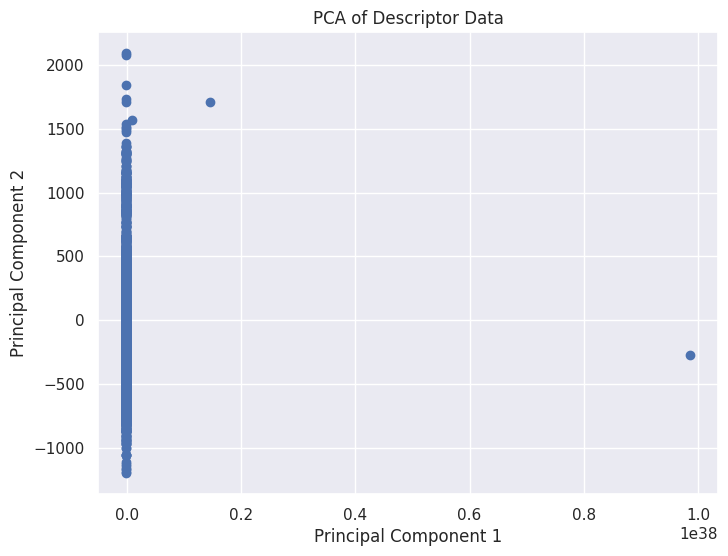

In [5]:
# @title The very first Principal Component Analysis (PCA) model
# @markdown Is there something... strange?
X = desc_GR_noNA.iloc[:,3:]

pca_v1 = PCA(n_components=10)
pca_v1_result = pca_v1.fit_transform(X)
principal_components = pca_v1.components_

plt.figure(figsize=(8, 6))
plt.scatter(pca_v1_result[:, 0], pca_v1_result[:, 1])
plt.title('PCA of Descriptor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [6]:
# @title Molecular descriptors normalization (and removal of descriptors with zero variances)

scaler_temp = preprocessing.StandardScaler()
norm_temp = pd.DataFrame(preprocessing.normalize(scaler_temp.fit_transform(desc_GR_noNA.iloc[:,3:])))
norm_temp.columns = desc_GR_noNA.iloc[:,3:].columns

desc_GR_normalized = pd.concat([desc_GR_noNA.iloc[:,:3], norm_temp], axis="columns")

desc_GR_normalized_noNA = desc_GR_normalized.dropna(axis="columns")
desc_GR_normalized_noNA

,BindingDB_ID,IC50,pIC50,Steroidal,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,50206900.0,0.03,10.523,-0.039395,-0.011719,-0.011719,0.009815,0.026200,-0.034880,0.108068,...,-0.028444,-0.045613,-0.013465,-0.003829,-0.003126,-0.011998,0.0,-0.016653,0.0,0.0
1,50203432.0,0.03,10.523,-0.039994,-0.013107,-0.013107,-0.061338,-0.036852,-0.141677,-0.087823,...,0.288401,-0.046307,-0.013670,-0.003888,-0.003173,-0.012181,0.0,-0.016907,0.0,0.0
2,50203441.0,0.04,10.398,-0.038914,-0.011665,-0.011665,-0.046306,-0.034739,-0.113941,-0.092279,...,-0.028097,-0.045056,-0.013301,-0.003783,-0.003088,-0.011852,0.0,-0.016450,0.0,0.0
3,50203413.0,0.05,10.301,-0.056544,-0.009001,-0.009001,-0.084538,0.077413,-0.128285,-0.079972,...,-0.040827,-0.065469,-0.019327,-0.005496,-0.004487,-0.017221,0.0,-0.023903,0.0,0.0
4,50250114.0,0.05,10.398,-0.043734,0.019889,0.019889,-0.059207,-0.002109,-0.080764,-0.070173,...,-0.031578,-0.050637,-0.014948,-0.004251,-0.003470,-0.013320,0.0,-0.018488,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,50216276.0,35000.00,4.456,-0.023738,-0.128330,-0.128330,0.079679,0.044149,0.097273,-0.021463,...,-0.017139,-0.027484,-0.008113,-0.002307,-0.001883,-0.007230,0.0,-0.010035,0.0,0.0
1699,145862.0,35000.00,4.456,-0.033880,-0.010098,-0.010098,0.171196,0.043450,0.036882,0.093160,...,-0.024462,-0.039227,-0.011580,-0.003293,-0.002688,-0.010319,0.0,-0.014322,0.0,0.0
1700,50318300.0,35900.00,4.507,0.051550,-0.001430,-0.001430,0.079939,0.001456,-0.002413,0.062505,...,-0.006951,-0.011147,-0.003291,-0.000936,-0.000764,-0.002932,0.0,-0.004070,0.0,0.0
1701,50004233.0,90000.00,4.046,-0.023659,-0.140180,-0.140180,-0.022864,0.137580,-0.005252,-0.054769,...,-0.017083,-0.027394,-0.008087,-0.002300,-0.001877,-0.007206,0.0,-0.010001,0.0,0.0


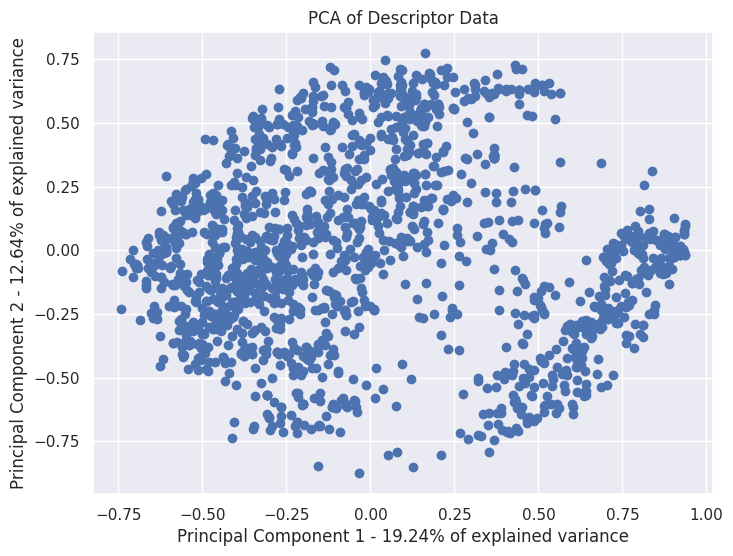

Explained variances of the 30 first principal components:
[0.19240112 0.12642366 0.09068229 0.0547732  0.04552284 0.04167478
 0.03290299 0.02942559 0.02715127 0.02355666 0.01960319 0.01696929
 0.01497722 0.01444506 0.01317786 0.01222038 0.01148995 0.01091692
 0.01021744 0.00927241 0.00853802 0.0078195  0.00722359 0.00682336
 0.00656848 0.00623587 0.00606826 0.0056196  0.0055658  0.00525273]


In [7]:
# @title Second PCA model
# @markdown Is this better?

X = desc_GR_normalized_noNA.iloc[:,3:]

pca_v2 = PCA(n_components=30)
pca_v2_result = pca_v2.fit_transform(X)
principal_components = pca_v2.components_


plt.figure(figsize=(8, 6))
plt.scatter(pca_v2_result[:, 0], pca_v2_result[:, 1])
plt.title('PCA of Descriptor Data')
plt.xlabel('Principal Component 1 - {:.2f}% of explained variance'.format(100*pca_v2.explained_variance_[0]))
plt.ylabel('Principal Component 2 - {:.2f}% of explained variance'.format(100*pca_v2.explained_variance_[1]))
plt.grid(True)
plt.show()

print("Explained variances of the 30 first principal components:")
print(pca_v2.explained_variance_)

In [8]:
# @title In 3D

fig2 = px.scatter_3d(x=pca_v2_result[:, 0], y=pca_v2_result[:, 1], z=pca_v2_result[:, 2], width=600, height=600)
fig2.update_traces(marker_size = 2)
fig2.show()

In [23]:
#@title Same PCA but with custom color parameters

descriptor_picker = widgets.Dropdown(options=desc_GR_normalized_noNA.columns[1:], value='MolWt')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
outs = widgets.Output()

def generation_PCA_fig_v2(x):
  with outs:
    clear_output()

    plt.figure(figsize=(8, 6))
    # plt.subplot(121)

    a = plt.scatter(pca_v2_result[:,0], pca_v2_result[:,1], c = desc_GR[descriptor_picker.value], cmap="turbo")
    plt.colorbar(a)
    plt.title('PCA of Descriptor Data')
    plt.xlabel('Principal Component 1 - {:.2f}% of explained variance'.format(100*pca_v2.explained_variance_[0]))
    plt.ylabel('Principal Component 2 - {:.2f}% of explained variance'.format(100*pca_v2.explained_variance_[1]))
    plt.grid(True)
    plt.show()
    # plt.subplot(122, projection='3d')
    # b = plt.scatter(pca_v2_result[:,0], pca_v2_result[:,1], pca_v2_result[:,2], c = desc_GR[descriptor_picker.value], cmap="turbo")
    # plt.colorbar(b)
    # plt.title('PCA of Descriptor Data')
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.grid(True)
    # plt.show()

display(descriptor_picker)
display(outs)
generation_PCA_fig_v2(descriptor_picker.value)
descriptor_picker.observe(generation_PCA_fig_v2, names='value')

Dropdown(index=9, options=('IC50', 'pIC50', 'Steroidal', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateI…

Output()

In [10]:
# @title Removal of highly correlated descriptors

X = desc_GR_normalized_noNA.iloc[:,3:]
elimcor = elimcor_sansY(X, 0.9)
desc_GR_nocorr = pd.concat([desc_GR_normalized_noNA.iloc[:,:3], X.iloc[:,elimcor["possetap"]]], axis="columns")
desc_GR_nocorr

,BindingDB_ID,IC50,pIC50,Steroidal,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,50206900.0,0.03,10.523,-0.039395,-0.011719,0.009815,0.026200,-0.034880,0.108068,0.023954,...,-0.028444,-0.045613,-0.013465,-0.003829,-0.003126,-0.011998,0.0,-0.016653,0.0,0.0
1,50203432.0,0.03,10.523,-0.039994,-0.013107,-0.061338,-0.036852,-0.141677,-0.087823,0.044046,...,0.288401,-0.046307,-0.013670,-0.003888,-0.003173,-0.012181,0.0,-0.016907,0.0,0.0
2,50203441.0,0.04,10.398,-0.038914,-0.011665,-0.046306,-0.034739,-0.113941,-0.092279,0.047893,...,-0.028097,-0.045056,-0.013301,-0.003783,-0.003088,-0.011852,0.0,-0.016450,0.0,0.0
3,50203413.0,0.05,10.301,-0.056544,-0.009001,-0.084538,0.077413,-0.128285,-0.079972,0.018061,...,-0.040827,-0.065469,-0.019327,-0.005496,-0.004487,-0.017221,0.0,-0.023903,0.0,0.0
4,50250114.0,0.05,10.398,-0.043734,0.019889,-0.059207,-0.002109,-0.080764,-0.070173,0.057282,...,-0.031578,-0.050637,-0.014948,-0.004251,-0.003470,-0.013320,0.0,-0.018488,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,50216276.0,35000.00,4.456,-0.023738,-0.128330,0.079679,0.044149,0.097273,-0.021463,-0.081203,...,-0.017139,-0.027484,-0.008113,-0.002307,-0.001883,-0.007230,0.0,-0.010035,0.0,0.0
1699,145862.0,35000.00,4.456,-0.033880,-0.010098,0.171196,0.043450,0.036882,0.093160,-0.089321,...,-0.024462,-0.039227,-0.011580,-0.003293,-0.002688,-0.010319,0.0,-0.014322,0.0,0.0
1700,50318300.0,35900.00,4.507,0.051550,-0.001430,0.079939,0.001456,-0.002413,0.062505,-0.011788,...,-0.006951,-0.011147,-0.003291,-0.000936,-0.000764,-0.002932,0.0,-0.004070,0.0,0.0
1701,50004233.0,90000.00,4.046,-0.023659,-0.140180,-0.022864,0.137580,-0.005252,-0.054769,-0.132925,...,-0.017083,-0.027394,-0.008087,-0.002300,-0.001877,-0.007206,0.0,-0.010001,0.0,0.0


In [11]:
#@title Third PCA model

X = desc_GR_nocorr.iloc[:,3:]

pca_v3 = PCA(n_components=30)
pca_v3_result = pca_v3.fit_transform(X)
principal_components = pca_v3.components_

descriptor_picker2 = widgets.Dropdown(options=desc_GR_nocorr.columns[1:], value='Steroidal')

outs = widgets.Output()

def generation_PCA_fig_v3(x):
  with outs:
    clear_output()
    plt.figure(figsize=(8, 6))
    a = plt.scatter(pca_v3_result[:,0], pca_v3_result[:,1], c = desc_GR[descriptor_picker2.value], cmap="turbo")
    plt.colorbar(a)
    plt.title('PCA of Descriptor Data')
    plt.xlabel('Principal Component 1 - {:.2f}% of explained variance'.format(100*pca_v3.explained_variance_[0]))
    plt.ylabel('Principal Component 2 - {:.2f}% of explained variance'.format(100*pca_v3.explained_variance_[1]))
    plt.grid(True)
    plt.show()

display(descriptor_picker2)
display(outs)
generation_PCA_fig_v3(descriptor_picker2.value)
descriptor_picker2.observe(generation_PCA_fig_v3, names='value')

Dropdown(index=2, options=('IC50', 'pIC50', 'Steroidal', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateI…

Output()

## <u>**K-means clustering**</u>

In [12]:
# @title Where are the steroidal compounds?

fig3 = px.scatter_3d(x=pca_v3_result[:, 0], y=pca_v3_result[:, 1], z=pca_v3_result[:, 2], width=600, height=600, color_continuous_scale=["red", "blue"], color=desc_GR["Steroidal"], labels={"color": "Steroidal"})
fig3.update_traces(marker_size = 2)
fig3.show()

In [24]:
# @title K-means clustering to generate X groups

X = desc_GR_nocorr.iloc[:,3:]

choice_nb_clusters = widgets.Dropdown(options=list(range(2,10)), value=2)
outs_kmeans = widgets.Output()

def on_nb_change(change):
  with outs_kmeans:
    clear_output()
    kmeans = KMeans(n_clusters=choice_nb_clusters.value, n_init=29, random_state=0)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    cluster_labels
    cluster_centers = pd.DataFrame(kmeans.cluster_centers_)
    cluster_centers.columns = X.columns
    cluster_centers_pca = pca_v3.transform(cluster_centers)
    plt.scatter(pca_v3_result[:, 0], pca_v3_result[:, 1], c=cluster_labels, cmap="Accent")
    plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], marker='o', c='red', s=20, label='Centroids')
    plt.title('KMeans Clustering with {} clusters'.format(choice_nb_clusters.value))
    plt.xlabel('Principal Component 1 - {:.2f}% of explained variance'.format(100*pca_v3.explained_variance_[0]))
    plt.ylabel('Principal Component 2 - {:.2f}% of explained variance'.format(100*pca_v3.explained_variance_[1]))
    plt.legend()
    plt.show()

    desc_GR_clustered = pd.concat([desc_GR_nocorr.iloc[:,:3], pd.DataFrame(cluster_labels, columns=["Cluster"]), desc_GR_nocorr.iloc[:,3:]], axis = "columns")
    display(desc_GR_clustered)

display(choice_nb_clusters)
display(outs_kmeans)

on_nb_change(2)
choice_nb_clusters.observe(on_nb_change, names='value')


Dropdown(options=(2, 3, 4, 5, 6, 7, 8, 9), value=2)

Output()

In [14]:
# @title With 3 clusters, by removing the right cluster that includes the steroids
# @ markdown Data have been re-normalized

X = desc_GR_nocorr.iloc[:,3:]
kmeans = KMeans(n_clusters=3, n_init=29, random_state=0)
kmeans.fit(X)
cluster_labels = kmeans.labels_
desc_GR_clustered = pd.concat([desc_GR_nocorr.iloc[:,:3], pd.DataFrame(cluster_labels, columns=["Cluster"]), desc_GR_nocorr.iloc[:,3:]], axis = "columns")

desc_GR_clustered_filtered = desc_GR.loc[desc_GR_clustered["Cluster"] != desc_GR_clustered.loc[1700,"Cluster"]]
desc_GR_clustered_filtered = desc_GR_clustered_filtered.dropna(axis="columns")
desc_GR_clustered_filtered.index = range(len(desc_GR_clustered_filtered))

# desc_GR_clustered_normalized = pd.concat([desc_GR_clustered_filtered.iloc[:,:4], (desc_GR_clustered_filtered.iloc[:,4:] - desc_GR_clustered_filtered.iloc[:,4:].mean()) / desc_GR_clustered_filtered.iloc[:,4:].std()], axis="columns")

scaler_temp = preprocessing.StandardScaler()
norm_temp = pd.DataFrame(preprocessing.normalize(scaler_temp.fit_transform(desc_GR_clustered_filtered.iloc[:,4:])))
norm_temp.columns = desc_GR_clustered_filtered.iloc[:,4:].columns

desc_GR_clustered_normalized = pd.concat([desc_GR_clustered_filtered.iloc[:,:4], norm_temp], axis="columns")
desc_GR_clustered_normalized_noNA = desc_GR_clustered_normalized.dropna(axis="columns")
desc_GR_clustered_normalized_noNA


X = desc_GR_clustered_normalized_noNA.iloc[:,4:]
elimcor = elimcor_sansY(X)
desc_GR_clustered_prep = pd.concat([desc_GR_clustered_normalized_noNA.iloc[:,:4], X.iloc[:,elimcor["possetap"]]], axis="columns")

X = desc_GR_clustered_prep.iloc[:,4:]

pca_v4 = PCA(n_components=10)
pca_v4_result = pca_v4.fit_transform(X)
principal_components = pca_v4.components_

descriptor_picker3 = widgets.Dropdown(options=desc_GR_clustered_prep.columns[1:], value='Steroidal')

outs3 = widgets.Output()

def generation_PCA_fig3(x):
  with outs3:
    clear_output()
    plt.figure(figsize=(8, 6))
    a = plt.scatter(pca_v4_result[:,0], pca_v4_result[:,1], c = desc_GR_clustered_prep[descriptor_picker3.value], cmap="turbo")
    plt.colorbar(a)
    plt.title('PCA of Descriptor Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()
    display(desc_GR_clustered_normalized_noNA)

display(descriptor_picker3)
display(outs3)
generation_PCA_fig3(descriptor_picker3.value)
descriptor_picker3.observe(generation_PCA_fig3, names='value')

Dropdown(index=2, options=('IC50', 'pIC50', 'Steroidal', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateI…

Output()

# <u>**Model \#1 - Multiple linear regression (quantitative)**</u>

Mean Squared Error (MSE) of Linear Regression: 0.55
Root Mean Squared Error (RMSE) of Linear Regression: 0.74
R-squared (R2) of Linear Regression: 0.50




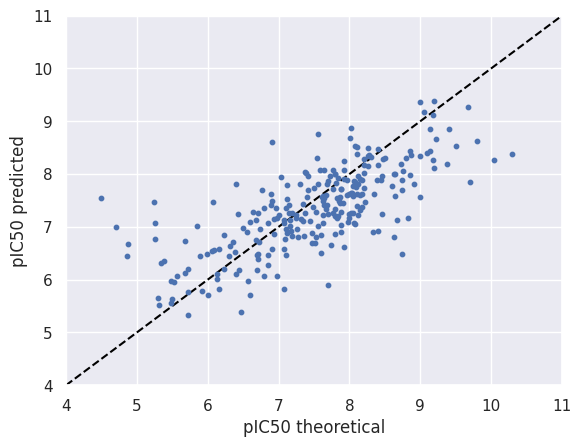

In [15]:
# @title Multiple linear regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = desc_GR_clustered_prep.iloc[:,4:]
y = desc_GR_clustered_prep.loc[:,"pIC50"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression(positive=True).fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


# Calculate mean squared error (for regression)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) of Linear Regression: {mse:.2f}")

print(f"Root Mean Squared Error (RMSE) of Linear Regression: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2) of Linear Regression: {r2:.2f}\n\n")

for i in range(len(y_pred)):
  if abs(y_pred[i]) > 15:
    print(X_test.index[i])
    # print(y_pred + "\n")

plt.scatter(y_test, y_pred, s=10, zorder=22)
plt.axline((0, 0), slope=1, linestyle="dashed", c="black")
plt.xlim([4,11])
plt.ylim([4,11])
plt.xlabel("pIC50 theoretical")
plt.ylabel("pIC50 predicted")
plt.show()

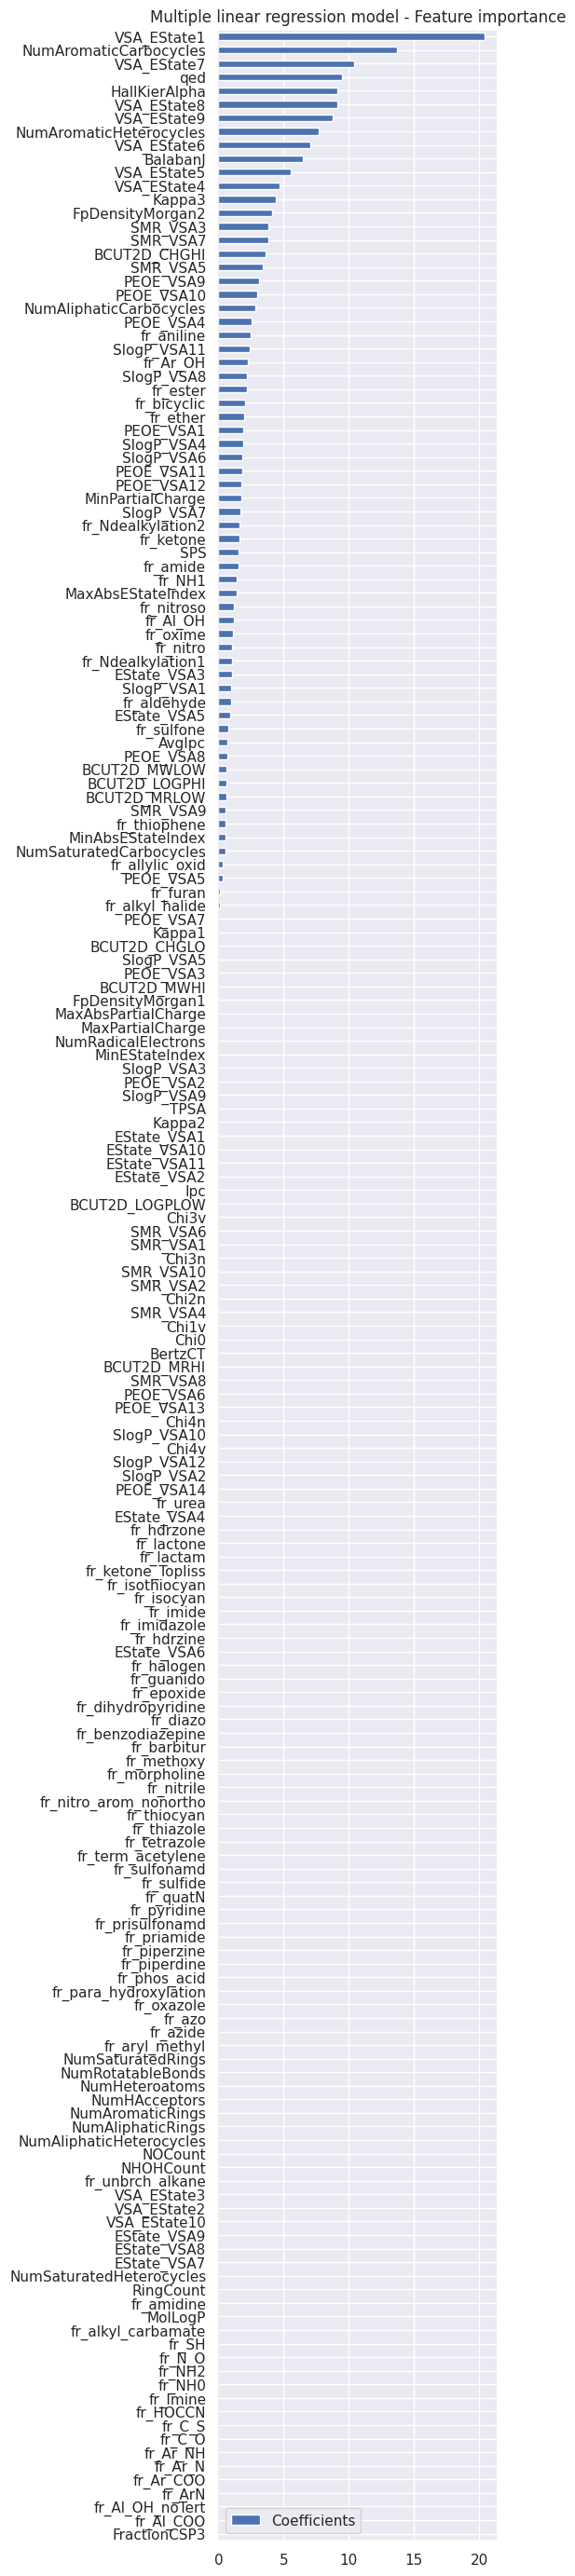

In [16]:
# @title Feature importance of the multiple linear regression model

coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index=X_train.columns
)
coefs = coefs.sort_values("Coefficients")
coefs.plot(kind="barh", figsize=(5, 35))
plt.title("Multiple linear regression model - Feature importance")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Only 49 descriptors left

Mean Squared Error (MSE) of Linear Regression: 0.72
Root Mean Squared Error (RMSE) of Linear Regression: 0.85
R-squared (R2) of Linear Regression: 0.31




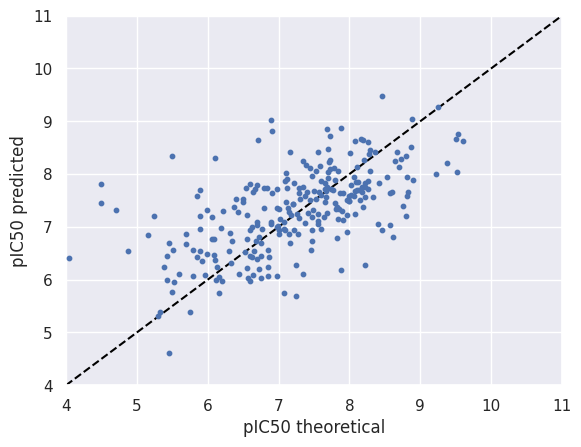

In [17]:
# @title Second multiple linear regression model if we remove the coefficients < 1

Xprep = desc_GR_clustered_prep.iloc[:,4:]
X = Xprep.loc[:,coefs["Coefficients"] > 1]
y = desc_GR_clustered_prep.loc[:,"pIC50"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Only {} descriptors left\n".format(len(X.columns)))

model2 = LinearRegression(positive=True).fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred2))

# Calculate mean squared error (for regression)
mse = mean_squared_error(y_test, y_pred2)
print(f"Mean Squared Error (MSE) of Linear Regression: {mse:.2f}")

print(f"Root Mean Squared Error (RMSE) of Linear Regression: {rmse:.2f}")

r2 = r2_score(y_test, y_pred2)
print(f"R-squared (R2) of Linear Regression: {r2:.2f}\n\n")

for i in range(len(y_pred2)):
  if abs(y_pred2[i]) > 15:
    print(X_test.index[i])
    # print(y_pred2 + "\n")

plt.scatter(y_test, y_pred2, s=10, zorder=22)
plt.axline((0, 0), slope=1, linestyle="dashed", c="black")
plt.xlim([4,11])
plt.ylim([4,11])
plt.xlabel("pIC50 theoretical")
plt.ylabel("pIC50 predicted")
plt.show()


# <u>**Model \#2 - Linear Discriminant Analysis (LDA) (qualitative)**</u>

In [18]:
# @title Separation of the dataset into 3 classes: Active/Less active/Inactive

active_picker = widgets.Dropdown(options=range(4,10), value=8, description="pIC50 limit of actives:", style=dict(description_width='initial'))
inactive_picker = widgets.Dropdown(options=range(4,10), value=6, description="pIC50 limit of inactives:", style=dict(description_width='initial'))

outs_active = widgets.Output()

def generation_active(x):
  with outs_active:
    clear_output()

    y = []
    y_color = []
    for i in desc_GR_clustered_prep.iloc[:,2]:
      if i > active_picker.value:
        y.append("Active")
        y_color.append("green")
      elif i < inactive_picker.value:
        y.append("Inactive")
        y_color.append("orange")
      else:
        y.append("LessActive")
        y_color.append("red")

    desc_GR_activity = pd.concat([desc_GR_clustered_prep.iloc[:,:4], pd.DataFrame(y, columns=["Activity"]), desc_GR_clustered_prep.iloc[:,4:]], axis = "columns")

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_v4_result[:,0], pca_v4_result[:,1], c = y_color)
    plt.title('PCA of Descriptor Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()
    print(desc_GR_activity["Activity"].value_counts())

display(active_picker)
display(inactive_picker)
display(outs_active)

generation_active(active_picker.value)
active_picker.observe(generation_active, names='value')
inactive_picker.observe(generation_active, names='value')

Dropdown(description='pIC50 limit of actives:', index=4, options=(4, 5, 6, 7, 8, 9), style=DescriptionStyle(de…

Dropdown(description='pIC50 limit of inactives:', index=2, options=(4, 5, 6, 7, 8, 9), style=DescriptionStyle(…

Output()

In [19]:
# @title In 3D
ygroup = []
y_color = []
for i in desc_GR_clustered_prep.iloc[:,2]:
  if i > active_picker.value:
    ygroup.append("Active")
  elif i < inactive_picker.value:
    ygroup.append("Inactive")
  else:
    ygroup.append("LessActive")

desc_GR_activity = pd.concat([desc_GR_clustered_prep.iloc[:,:4], pd.DataFrame(ygroup, columns=["Activity"]), desc_GR_clustered_prep.iloc[:,4:]], axis = "columns")

fig2 = px.scatter_3d(x=pca_v4_result[:, 0], y=pca_v4_result[:, 1], z=pca_v4_result[:, 2], color=ygroup, width=1000, height=800)
fig2.update_traces(marker_size = 2)
fig2.show()

In [20]:
# @title Linear Discriminant Analysis with 3 classes
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset (or replace this with your dataset)
y = [1 if i > active_picker.value else 0 for i in desc_GR_clustered_prep.iloc[:,2]]
desc_GR_activity = pd.concat([desc_GR_clustered_prep.iloc[:,:4], pd.DataFrame(y, columns=["Activity"]), desc_GR_clustered_prep.iloc[:,4:]], axis = "columns")

ygroup = []
ycat = []
for i in desc_GR_clustered_prep.iloc[:,2]:
  if i > active_picker.value:
    ygroup.append("Active")
    ycat.append(1)
  elif i < inactive_picker.value:
    ygroup.append("Inactive")
    ycat.append(-1)
  else:
    ygroup.append("LessActive")
    ycat.append(0)

desc_GR_activity = pd.concat([desc_GR_clustered_prep.iloc[:,:4], pd.DataFrame(ygroup, columns=["Activity_Label"]), pd.DataFrame(ycat, columns=["Activity"]), desc_GR_clustered_prep.iloc[:,4:]], axis = "columns")

X = desc_GR_activity.iloc[:,6:]
y = desc_GR_activity.loc[:,"Activity"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an LDA instance
lda = LinearDiscriminantAnalysis(store_covariance=True)

# Fit LDA on the training data
lda.fit(X_train, y_train)

# Predict the classes on the test set
y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)


print("Upper pIC50 value = {}".format(active_picker.value))
print("Lower pIC50 value = {}".format(inactive_picker.value))

print(f"Accuracy of Linear Discriminant Analysis: {accuracy:.2f}")




Upper pIC50 value = 8
Lower pIC50 value = 6
Accuracy of Linear Discriminant Analysis: 0.73


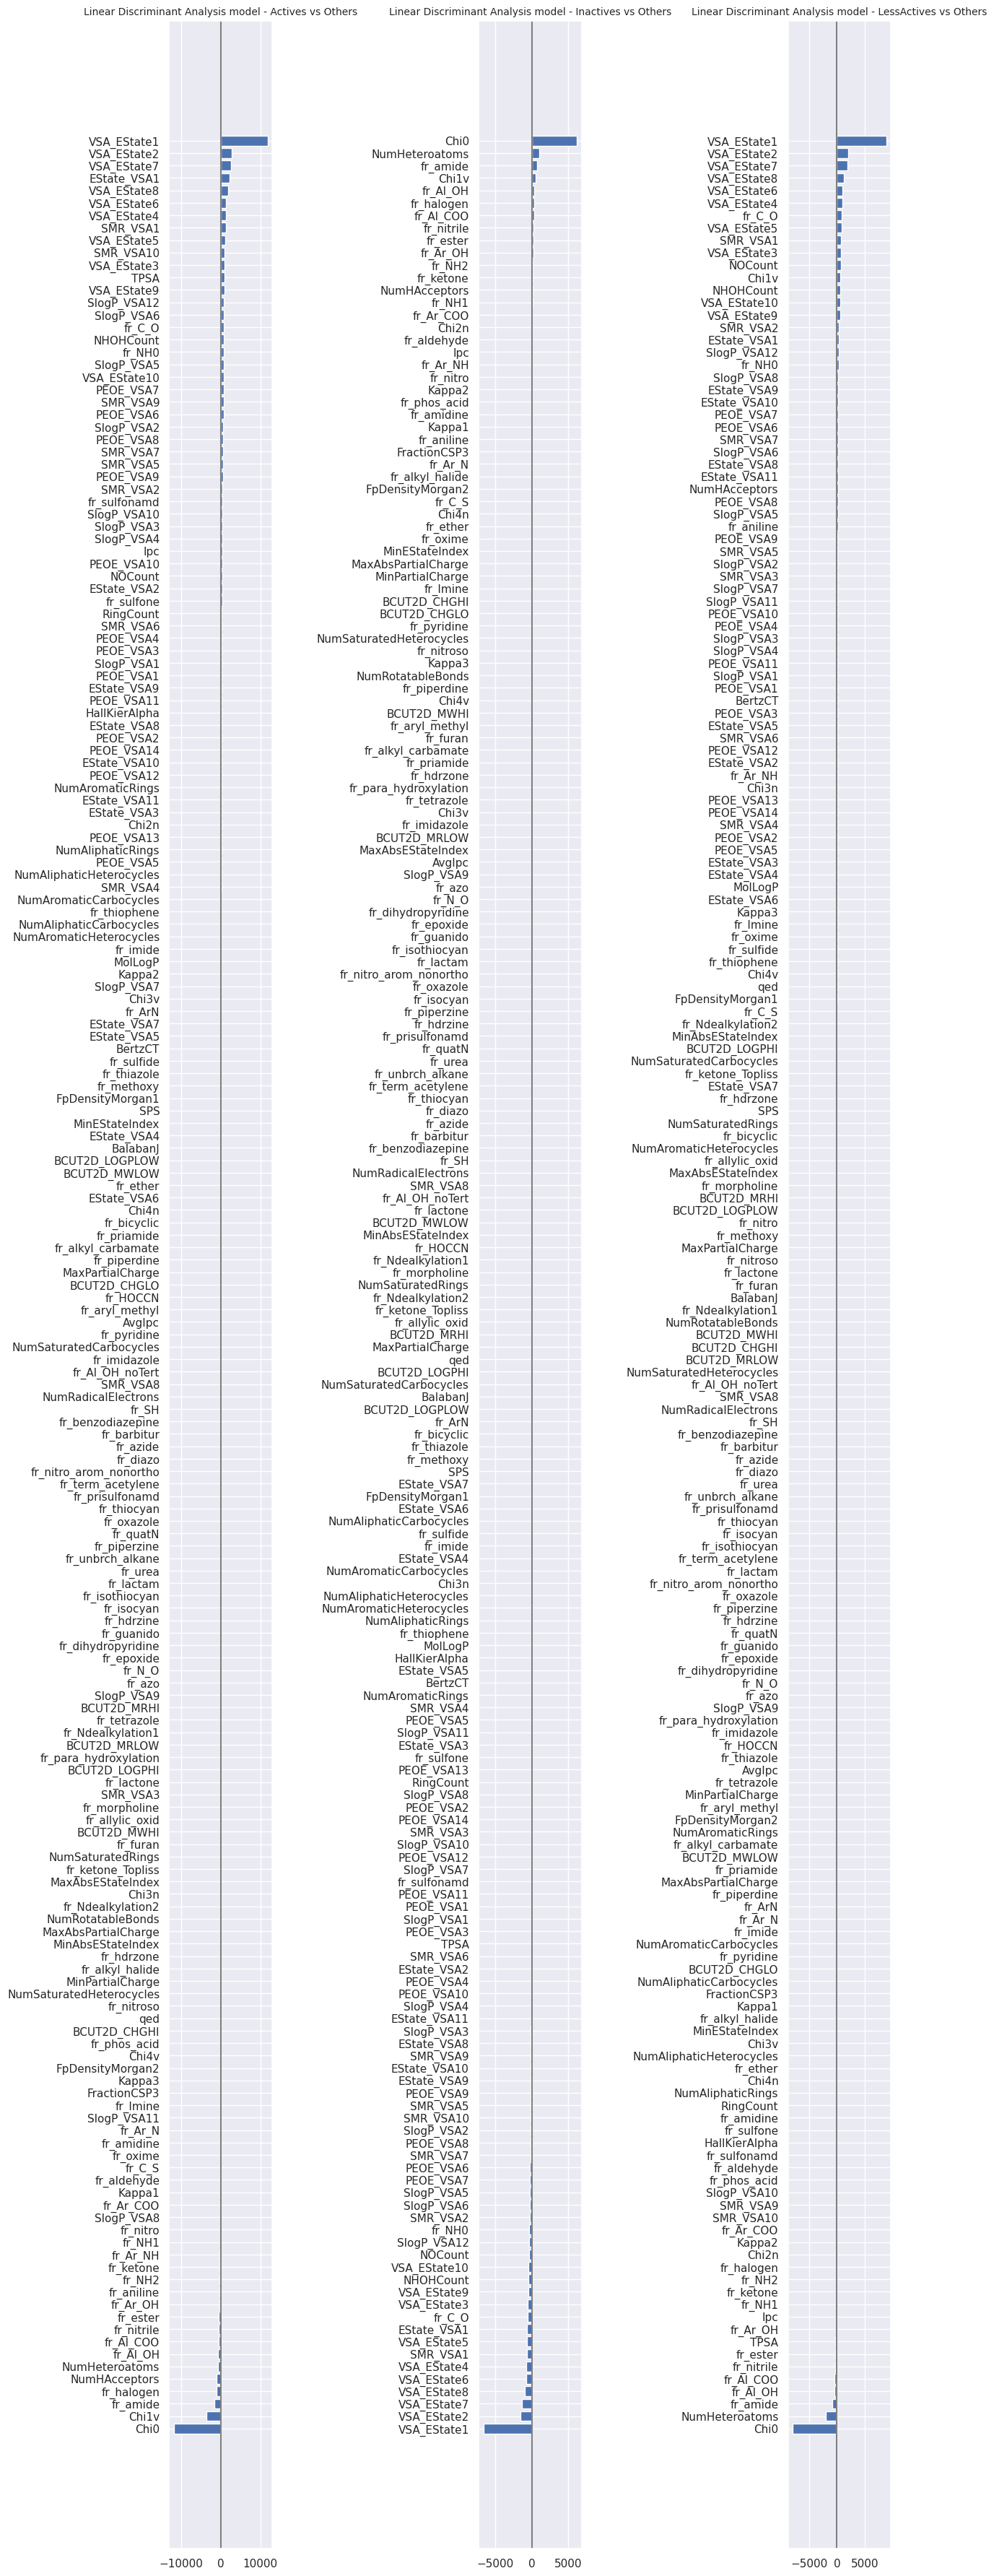

In [21]:
# @title Feature importance of the 3 classes Linear Discriminant Analysis

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 35))
fig.subplots_adjust(left=2, right=3, top=1, bottom=0, wspace=2)
# fig.tight_layout()

coefs1 = pd.DataFrame(lda.coef_[0], columns=["Coefficients"], index=X_train.columns)
coefs1 = coefs1.sort_values("Coefficients")

coefs2 = pd.DataFrame(lda.coef_[1], columns=["Coefficients"], index=X_train.columns)
coefs2 = coefs2.sort_values("Coefficients")

coefs3 = pd.DataFrame(lda.coef_[2], columns=["Coefficients"], index=X_train.columns)
coefs3 = coefs3.sort_values("Coefficients")

# coefs1 = coefs1.sort_values("Coefficients")
# coefs1.plot(kind="barh", figsize=(5, 15), ax=axes[1])
# plt.title("Linear Discriminant Analysis model - Feature importance")
# plt.axvline(x=0, color=".5")
# coefs2.plot(kind="barh", figsize=(5, 15), ax=axes[0])


axes[0].barh(np.arange(len(coefs1)), width=coefs1["Coefficients"]);
axes[0].set_title("Linear Discriminant Analysis model - Actives vs Others", fontdict={'fontsize':10});
axes[0].axvline(x=0, color=".5");
axes[0].yaxis.set_ticks(np.arange(len(coefs1)));
axes[0].yaxis.set_ticklabels(coefs1.index);

axes[1].barh(np.arange(len(coefs2)), width=coefs2["Coefficients"]);
axes[1].set_title("Linear Discriminant Analysis model - Inactives vs Others", fontdict={'fontsize':10});
axes[1].axvline(x=0, color=".5");
axes[1].yaxis.set_ticks(np.arange(len(coefs2)));
axes[1].yaxis.set_ticklabels(coefs2.index);

axes[2].barh(np.arange(len(coefs3)), width=coefs3["Coefficients"]);
axes[2].set_title("Linear Discriminant Analysis model - LessActives vs Others", fontdict={'fontsize':10});
axes[2].axvline(x=0, color=".5");
axes[2].yaxis.set_ticks(np.arange(len(coefs3)));
axes[2].yaxis.set_ticklabels(coefs3.index);

LDA models are currently being generated. It will take ~1 min


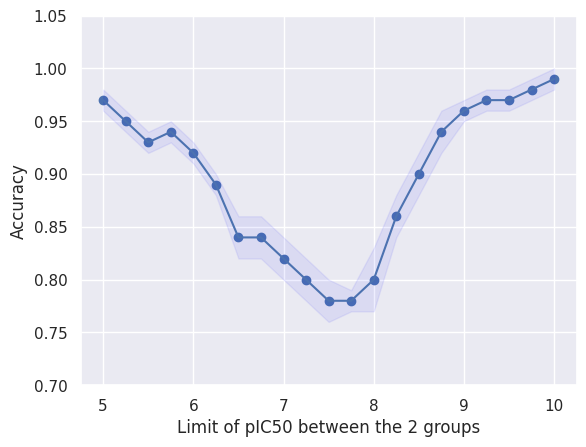

,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,...,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
Accuracy mean,0.97,0.95,0.93,0.94,0.92,0.89,0.84,0.84,0.82,0.80,...,0.78,0.80,0.86,0.90,0.94,0.96,0.97,0.97,0.98,0.99
Accuracy std,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,...,0.01,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01
Total actives,1281.00,1267.00,1229.00,1177.00,1132.00,1071.00,1007.00,917.00,838.00,727.00,...,487.00,351.00,217.00,153.00,105.00,67.00,40.00,27.00,13.00,10.00
Total inactives,22.00,36.00,74.00,126.00,171.00,232.00,296.00,386.00,465.00,576.00,...,816.00,952.00,1086.00,1150.00,1198.00,1236.00,1263.00,1276.00,1290.00,1293.00


In [25]:
# @title Linear Discriminant Analysis with 2 classes, 21 pIC50 limits, and Cross-Validation

print("\033[1mLDA models are currently being generated. It will take ~1 min\033[0m")

accuracies_mean = []
accuracies_sd = []
accuracies_split = []
accuracies_nbActives = []
accuracies_nbInactives = []

for pic50_limit in [j/100 for j in range(500,1001,25)]:
  ygroup2 = []
  ycat2 = []
  for i in desc_GR_clustered_prep.iloc[:,2]:
    if i > pic50_limit:
      ygroup2.append("Active")
      ycat2.append(1)
    else:
      ygroup2.append("Inactive")
      ycat2.append(0)

  desc_GR_activity2 = pd.concat([desc_GR_clustered_prep.iloc[:,:4], pd.DataFrame(ygroup2, columns=["Activity_Label"]), pd.DataFrame(ycat2, columns=["Activity"]), desc_GR_clustered_prep.iloc[:,4:]], axis = "columns")

  accuracies_nbInactives.append(desc_GR_activity2["Activity_Label"].value_counts()["Inactive"])
  accuracies_nbActives.append(desc_GR_activity2["Activity_Label"].value_counts()["Active"])

  X2 = desc_GR_activity2.iloc[:,6:]
  y2 = desc_GR_activity2.loc[:,"Activity"]

  X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
  lda2 = LinearDiscriminantAnalysis(store_covariance=True)
  lda2.fit(X_train2, y_train2)

  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import RepeatedStratifiedKFold
  y_pred2 = lda2.predict(X_test2)

  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  scores = cross_val_score(lda2, X2, y2, scoring='accuracy', cv=cv, n_jobs=-1)


  accuracy2 = accuracy_score(y_test2, y_pred2)

  accuracies_mean.append(round(np.mean(scores), 2))
  accuracies_sd.append(round(np.std(scores), 2))
  accuracies_split.append(pic50_limit)


plt.scatter(accuracies_split, accuracies_mean)
plt.plot(accuracies_split, accuracies_mean)
plt.fill_between(accuracies_split, [i-j for i,j in zip(accuracies_mean,accuracies_sd)], [i+j for i,j in zip(accuracies_mean,accuracies_sd)], color="#0000FF11")
plt.xlabel("Limit of pIC50 between the 2 groups")
plt.ylabel("Accuracy")
plt.ylim([0.7,1.05])
plt.show()

pd.DataFrame([accuracies_mean, accuracies_sd, accuracies_nbActives, accuracies_nbInactives], index=["Accuracy mean", "Accuracy std", "Total actives", "Total inactives"], columns=accuracies_split)



## <u>**Random notes**</u>

### **Subdivided Surface Areas descriptors**
The Subdivided Surface Areas are descriptors based on an approximate accessible van der Waals surface area (in Å2) calculation for each atom, along with some other atomic property.

- VSA = Van der Waals Surface Area
- SMR = Sum of Molecular refractivity
- PEOE = Gasteiger-Marsili PEOE algorithm to calculate a definition of atomic partial charges
- SLogP = Sum of LogP of atom contributions
- EState = Electrotopological States. Electronic characteristics by taking into account the atom type, bond types, connectivity within the molecules.

<br />

#### **SLogP_VSA** = Contribution of each atom in the molecule to the LogP  compared along with the contribution of each atom to an approximate molecular surface area.
SlogP bins = [-0.4, -0.2, 0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]  
Ex: SLogP_VSA1 = Sum of surface areas of atoms with an atomic LogP below -0.4

<br />

#### **SMR_VSA** = Contribution of each atom in the molecule to the Molecular Refractivity compared along with the contribution of each atom to an approximate molecular surface area.
SMR bins = [1.29, 1.82, 2.24, 2.45, 2.75, 3.05, 3.63, 3.8, 4.0]  
Ex: SMR_VSA2 = Sum of surface areas of atoms with an atomic molecular refractivity between 1.29 and 1.82

<br />

#### **PEOE_VSA** = Contribution of each atom partial charge in the molecule compared along with the contribution of each atom to an approximate molecular surface area.
PEOE bins = [-.3, -.25, -.20, -.15, -.10, -.05, 0, .05, .10, .15, .20, .25, .30]  
Ex: PEOE_VSA14 = Sum of surface areas of atoms with partial charges greater than 0.30

<br />

#### **EState_VSA // VSA_EState** = Contribution of each atom electronic characteristics compared along with the contribution of each atom to an approximate molecular surface area // Contribution of each atom electronic characteristics compared along with the contribution of each atom electronic characteristics
vsaBins=[4.78,5.00,5.410,5.740,6.00,6.07,6.45,7.00,11.0]  
estateBins=[-0.390,0.290,0.717,1.165,1.540,1.807,2.05,4.69,9.17,15.0]  
Ex.1: EState_VSA1 = Sum of surface areas of atoms with EStates lower than -0.390  
Ex.2: VSA_EState1 = Sum of EState of atoms with Atomic Surface Areas lower than 4.78 Å2

